In [2]:
from urllib.request import urlopen  # Library for urlopen
from bs4 import BeautifulSoup  # Library for html parser (scraper), lxml is also nice
import pandas as pd
import numpy as np
import re
import sys
sys.path.append('..') 
from uni_cache.cache_function import cache_function
import pymysql
import collections
import mysql_credits

from __future__ import division, print_function
import os.path
from pathlib import Path
import json
from pandas.io.json import json_normalize 

# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

In [3]:
from matplotlib import pyplot as plt

import plotly.plotly as py
import plotly.graph_objs as go 

import pandas_datareader.data as web

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import matplotlib
import plotly

from datetime import datetime, date, time, timedelta 
import time as main_time
import calendar

plotly.tools.set_credentials_file(username='st035004', api_key='zAZHt6Yz62WilMD5pKIE')
pd.options.display.max_columns = 250
pd.options.display.max_rows = 200
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline

In [4]:
connection = pymysql.connect(
    host=mysql_credits.db_host,
    user=mysql_credits.db_user,
    password=mysql_credits.db_password,
    db=mysql_credits.db,
    charset='utf8mb4',
    cursorclass=pymysql.cursors.DictCursor
)


In [5]:
cursor = connection.cursor()

In [6]:
sql='''
select article_id, article_rating, article_uni, article_pub_date
from article
WHERE (article_rating>0)
'''

In [7]:
cursor.execute(sql)

raw = cursor.fetchall()

df = pd.DataFrame(raw, columns=[i[0] for i in cursor.description])

In [8]:
df.article_pub_date=pd.to_datetime(df.article_pub_date)

In [9]:
df['year'] = pd.DatetimeIndex(df['article_pub_date']).year
df['month'] = pd.DatetimeIndex(df['article_pub_date']).month
df['week'] = pd.DatetimeIndex(df['article_pub_date']).week
df['month_year']=pd.DatetimeIndex(df['article_pub_date']).week + pd.DatetimeIndex(df['article_pub_date']).year * 100
df['dayofweek']=pd.DatetimeIndex(df['article_pub_date']).dayofweek
df['days'] = pd.DatetimeIndex(df['article_pub_date']).day

In [10]:
print(df.shape)
df.head()

(7858, 10)


,article_id,article_rating,article_uni,article_pub_date,year,month,week,month_year,dayofweek,days
0,2161,3,Oxford Brookes,2017-03-19,2017,3,11,201711,6,19
1,2162,2,Oxford Brookes,2017-02-07,2017,2,6,201706,1,7
2,2163,4,Oxford Brookes,2016-12-17,2016,12,50,201650,5,17
3,2164,2,Oxford Brookes,2016-12-15,2016,12,50,201650,3,15
4,2165,3,Oxford Brookes,2016-12-02,2016,12,48,201648,4,2


In [11]:
df.article_rating.min()

1

In [12]:
from datetime import datetime, date, time, timedelta 
data_first_ranking=datetime.combine(date(2010,1,1), time(0,0))
print (data_first_ranking)

2010-01-01 00:00:00


In [13]:
print(df[df.article_pub_date>=data_first_ranking].shape)
df[df.article_pub_date>=data_first_ranking].head()

(4182, 10)


,article_id,article_rating,article_uni,article_pub_date,year,month,week,month_year,dayofweek,days
0,2161,3,Oxford Brookes,2017-03-19,2017,3,11,201711,6,19
1,2162,2,Oxford Brookes,2017-02-07,2017,2,6,201706,1,7
2,2163,4,Oxford Brookes,2016-12-17,2016,12,50,201650,5,17
3,2164,2,Oxford Brookes,2016-12-15,2016,12,50,201650,3,15
4,2165,3,Oxford Brookes,2016-12-02,2016,12,48,201648,4,2


In [14]:
df.article_uni.nunique()

81

pd.DataFrame({'article_uni':df.article_uni.unique()}).to_csv('article_uni.csv')

In [15]:
df_ranking=pd.read_csv('article_uni.csv', index_col=0)

In [16]:
print(df_ranking.shape)
df_ranking.head()

(80, 15)


,article_uni,country,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Oxford Brookes,UK,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,401.00,401.00,401.00
1,University of Cambridge,UK,nan,nan,nan,nan,nan,6.00,6.00,7.00,7.00,5.00,4.00,4.00,2.00
2,London School of Economics and Political Science,UK,nan,nan,nan,nan,nan,86.00,47.00,39.00,32.00,34.00,23.00,25.00,25.00
3,University of Edinburgh,UK,nan,nan,nan,nan,nan,40.00,36.00,32.00,39.00,36.00,24.00,27.00,27.00
4,University of Manchester,UK,nan,nan,nan,nan,nan,87.00,48.00,49.00,58.00,52.00,56.00,55.00,54.00


In [17]:
df.article_uni.replace('The London School of Economics and Political Science (United-Kingdom)',
    'London School of Economics and Political Science', inplace=True)

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [19]:
scaler=StandardScaler()

In [20]:
uni_cluster_1=df[df.article_rating==df.article_rating.max()].article_uni.unique()
uni_cluster_2=list(set(df.article_uni.unique())-set(uni_cluster_1))

In [24]:
df[df.article_uni.isin(uni_cluster_1)].article_rating.values*2/10.max()

1.0

In [25]:
df['article_rating'][df.article_uni.isin(uni_cluster_1)]=df[df.article_uni.isin(uni_cluster_1)].article_rating.values*2/10#scaler.fit_transform(df[df.article_uni.isin(uni_cluster_1)].article_rating.values)

In [26]:
df['article_rating'][df.article_uni.isin(uni_cluster_2)]=df[df.article_uni.isin(uni_cluster_2)].article_rating.values*2.5/10#scaler.fit_transform(df[df.article_uni.isin(uni_cluster_2)].article_rating.values)

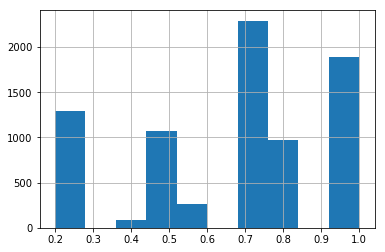

In [27]:
df.article_rating.hist()

a=pd.pivot_table(df,index=["article_uni"],values=["article_rating"],aggfunc=[len,np.mean], columns='year')
a

In [28]:
df_ranking.sort_values(['article_uni'],inplace=True)

In [29]:
df_ranking.head()

,article_uni,country,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
34,Aberystwyth University,UK,nan,nan,nan,nan,nan,nan,276.00,276.00,301.00,351.00,301.00,301.00,301.00
35,Anglia Ruskin University,UK,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,301.00,301.00
71,Boston University,USA,nan,nan,nan,nan,nan,59.00,54.00,54.00,50.00,57.00,64.00,64.00,70.00
61,Brown University,USA,nan,nan,nan,nan,nan,55.00,49.00,51.00,52.00,54.00,51.00,51.00,50.00
21,Cardiff Metropolitan University,UK,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


b=df[df.article_pub_date>=data_first_ranking].groupby(['article_uni', 'year']).article_rating.agg(lambda x:x.value_counts().index[0]).reset_index()

In [40]:
b=df[df.article_pub_date>=data_first_ranking].groupby(['article_uni', 'year']).article_rating.agg({'article_rating_mean':'mean',
                                                       'article_rating_count':'count',
                                                        'article_rating_moda':lambda x:x.value_counts().index[0]}).reset_index()
b['ranking']=np.zeros((1, b.shape[0]))[0]
b.head()

,article_uni,year,article_rating_mean,article_rating_count,article_rating_moda,ranking
0,Aberystwyth University,2015,0.81,116,0.80,0.00
1,Aberystwyth University,2016,0.80,8,0.80,0.00
2,Anglia Ruskin University,2015,0.76,76,0.80,0.00
3,Anglia Ruskin University,2016,0.56,10,0.60,0.00
4,Anglia Ruskin University,2017,0.56,10,0.80,0.00


In [41]:
for name in b.article_uni.unique():
    for year in b[b.article_uni==name].year:
        #print(year)
        b['ranking'][(b.article_uni==name)&(b.year==year)]=df_ranking[(df_ranking.article_uni==name)][str(year)].values[0]

In [42]:
b=b[(~b.ranking.isnull())]

In [43]:
for year in np.sort(b.year.unique()):
    print(year, round(np.corrcoef(b[(b.year==year)].article_rating_mean, b[(b.year==year)].ranking)[1,0],2))

2010 0.13
2011 0.08
2012 0.23
2013 0.1
2014 0.13
2015 0.37
2016 0.37
2017 0.34


In [44]:
for year in np.sort(b.year.unique()):
    print(year, round(np.corrcoef(b[(b.year==year)].article_rating_moda, b[(b.year==year)].ranking)[1,0],2))

2010 0.18
2011 0.1
2012 0.14
2013 0.03
2014 -0.03
2015 0.36
2016 0.33
2017 0.37


In [45]:
df_all=pd.merge(b, df_ranking[['article_uni','country']], on=['article_uni'])

In [46]:
df_all.head()

,article_uni,year,article_rating_mean,article_rating_count,article_rating_moda,ranking,country
0,Aberystwyth University,2015,0.81,116,0.80,301.00,UK
1,Aberystwyth University,2016,0.80,8,0.80,301.00,UK
2,Anglia Ruskin University,2016,0.56,10,0.60,301.00,UK
3,Anglia Ruskin University,2017,0.56,10,0.80,301.00,UK
4,Boston University,2010,0.49,17,0.25,59.00,USA


In [77]:
import plotly.plotly as py
from plotly.grid_objs import Grid, Column
from plotly.tools import FigureFactory as FF 

import pandas as pd
import time

In [78]:
years_from_col = set(df_all['year'])
years_ints = sorted(list(years_from_col))
years = [str(year) for year in years_ints]

# make list of continents
countries = []
for country in df_all['country']:
    if country not in countries: 
        countries.append(country)

columns = []
# make grid
for year in years:
    for country in countries:
        df_by_year = df_all[df_all['year'] == int(year)]
        df_by_year_and_cont = df_by_year[df_by_year['country'] == country]
        for col_name in df_by_year_and_cont:
            #print(col_name)
            # each column name is unique
            column_name = '{year}_{country}_{header}_gapminder_grid'.format(
                year=year, country=country, header=col_name
            )
            a_column = Column(list(df_by_year_and_cont[col_name]), column_name)
            columns.append(a_column)

# upload grid
grid = Grid(columns)
url = py.grid_ops.upload(grid, 'gapminder_grid'+str(time.time()), auto_open=False)
url

'https://plot.ly/~st035004/128/'

In [79]:
figure = {
    'data': [],
    'layout': {},
    'frames': [],
    'config': {'scrollzoom': True}
}

# fill in most of layout
figure['layout']['yaxis'] = {'range': [-50, 200], 'title': 'Ranking un THE', 'gridcolor': '#FFFFFF'}
figure['layout']['xaxis'] = {'range': [-0.1, 1.1], 'title': 'Ranking mean', 'gridcolor': '#FFFFFF'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['plot_bgcolor'] = 'rgb(223, 232, 243)'

In [80]:
figure['layout']['sliders'] = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'text-before-value-on-display',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 1000, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': [...]
}

In [81]:
{
    'method': 'animate',
    'label': 'label-for-frame',
    'value': 'value-for-frame(defaults to label)',
    'args': [{'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate'}
    ],
}

{'args': [{'frame': {'duration': 300, 'redraw': False}, 'mode': 'immediate'}],
 'label': 'label-for-frame',
 'method': 'animate',
 'value': 'value-for-frame(defaults to label)'}

In [82]:
sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Year:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

In [83]:
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

custom_colors = {
    'UK': 'rgb(171, 99, 250)',
    'USA': 'rgb(230, 99, 250)',
    'Canada': 'rgb(99, 110, 250)',
}

column_name = '{year}_{country}_{header}_gapminder_grid'.format(
                year=year, country=country, header=col_name
            )

In [84]:
df_all.country.unique()

array(['UK', 'USA', 'Canada'], dtype=object)

In [85]:
col_name_template = '{year}_{country}_{header}_gapminder_grid'
year = df_all.year.min()
for country in countries:
    data_dict = {
        'xsrc': grid.get_column_reference(col_name_template.format(
            year=year, country=country, header='article_rating_mean'
        )),
        'ysrc': grid.get_column_reference(col_name_template.format(
            year=year, country=country, header='ranking'
        )),
        'mode': 'markers',
        'textsrc': grid.get_column_reference(col_name_template.format(
            year=year, country=country, header='article_uni'
        )),
        'marker': {
            'sizemode': 'area',
            'sizeref': 0.05,
            'sizesrc': grid.get_column_reference(col_name_template.format(
                 year=year, country=country, header='article_rating_count'
            )),
            'color': custom_colors[country]
        },
        'name': country
    }
    figure['data'].append(data_dict)

In [86]:
for year in years:
    frame = {'data': [], 'name': str(year)}
    for country in countries:
        data_dict = {
            'xsrc': grid.get_column_reference(col_name_template.format(
                year=year, country=country, header='article_rating_mean'
            )),
            'ysrc': grid.get_column_reference(col_name_template.format(
                year=year, country=country, header='ranking'
            )),
            'mode': 'markers',
            'textsrc': grid.get_column_reference(col_name_template.format(
                year=year, country=country, header='article_uni', 
                )),
            'marker': {
                'sizemode': 'area',
                'sizeref': 0.05,
                'sizesrc': grid.get_column_reference(col_name_template.format(
                    year=year, country=country, header='article_rating_count'
                )),
                'color': custom_colors[country]
            },
            'name': country
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

figure['layout']['sliders'] = [sliders_dict]

In [87]:
py.icreate_animations(figure, 'gapminder_example'+str(time.time()))

In [88]:
import seaborn as sns

In [93]:
df_all.head()

,article_uni,year,article_rating_mean,article_rating_count,article_rating_moda,ranking,country
0,Aberystwyth University,2015,0.81,116,0.80,301.00,UK
1,Aberystwyth University,2016,0.80,8,0.80,301.00,UK
2,Anglia Ruskin University,2016,0.56,10,0.60,301.00,UK
3,Anglia Ruskin University,2017,0.56,10,0.80,301.00,UK
4,Boston University,2010,0.49,17,0.25,59.00,USA


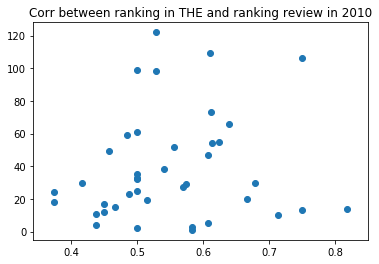

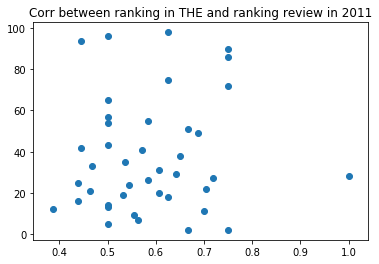

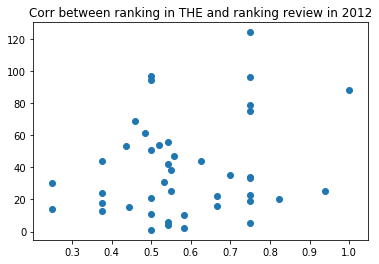

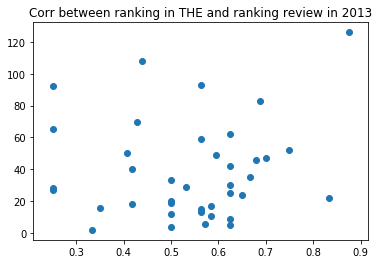

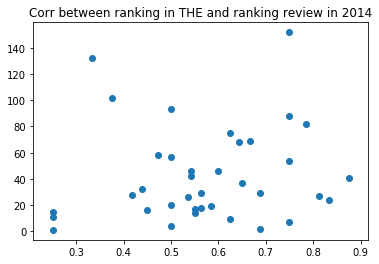

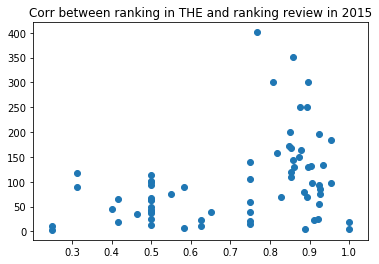

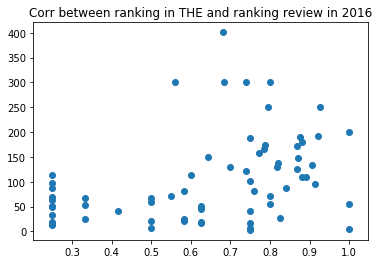

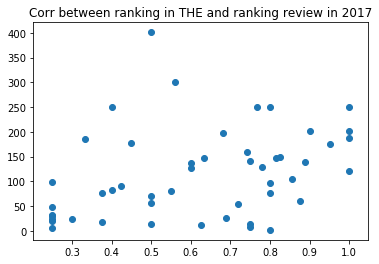

In [100]:
for i in  np.sort(df_all.year.unique()):
    plt.scatter(df_all[df_all.year==i].article_rating_mean,
           df_all[df_all.year==i].ranking)
    plt.title('Corr between ranking in THE and ranking review in {:0.0f}'.format(i))
    plt.show()

In [ ]:
df_all.article_rating_count

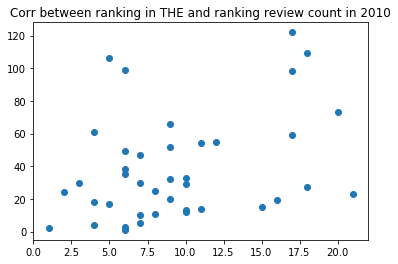

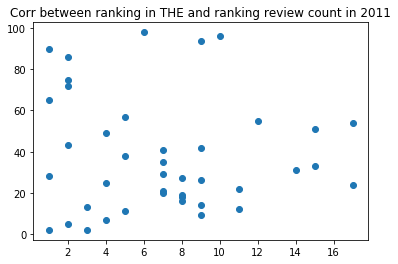

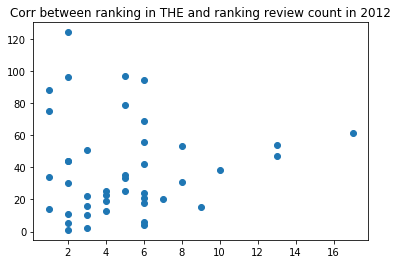

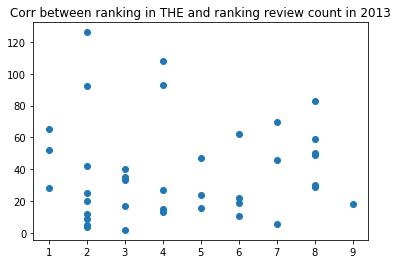

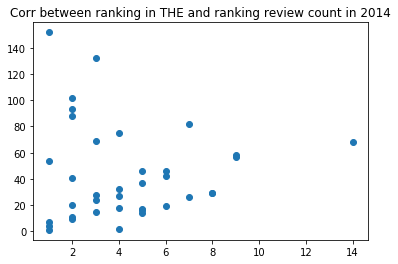

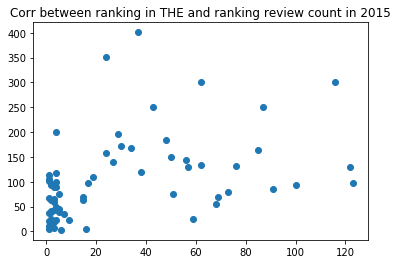

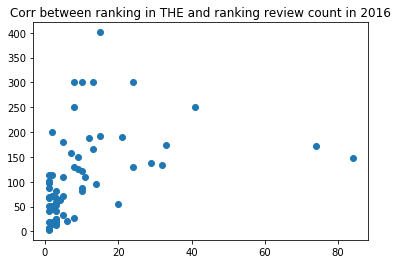

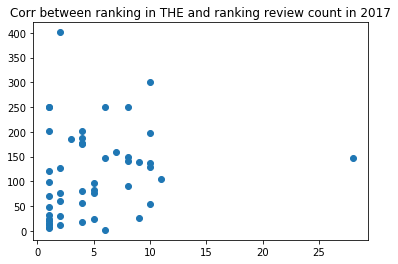

In [101]:
for i in  np.sort(df_all.year.unique()):
    plt.scatter(df_all[df_all.year==i].article_rating_count,
           df_all[df_all.year==i].ranking)
    plt.title('Corr between ranking in THE and ranking review count in {:0.0f}'.format(i))
    plt.show()

(array([ 321.,   30.,    9.,    4.,    5.,    6.,    3.,    2.,    1.,    3.]),
 array([   1. ,   13.2,   25.4,   37.6,   49.8,   62. ,   74.2,   86.4,
          98.6,  110.8,  123. ]),
 <a list of 10 Patch objects>)

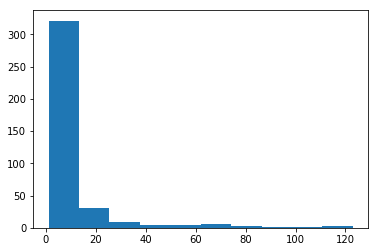

In [102]:
plt.hist(df_all.article_rating_count)

In [110]:
import selenium

In [111]:
from selenium import webdriver

In [115]:
browser = webdriver.Chrome(executable_path="..\\chromedriver.exe")

browser = webdriver.Edge(executable_path="..\\MicrosoftWebDriver.exe")

In [117]:
url = "https://www.niche.com/colleges/stanford-university/reviews/"
browser.get(url)

In [120]:
browser.find_element_by_css_selector('.icon-arrowright-thin--pagination').click()

In [121]:
browser.page_source

'<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" lang="en" class="wf-sourcesanspro-n4-active wf-sourcesanspro-n6-active wf-sourcesanspro-n7-active wf-sourcesanspro-n3-active wf-active" style=""><head><meta charset="utf-8" /><meta http-equiv="x-ua-compatible" content="ie=edge" /><meta name="viewport" content="width=device-width, user-scalable=no, initial-scale=1" /><meta property="fb:app_id" content="298822776951871" /><meta property="og:site_name" content="Niche" /><meta property="og:locale" content="en_US" /><meta name="msapplication-TileColor" content="#FFFFFF" /><meta name="msapplication-TileImage" content="https://d33a4decm84gsn.cloudfront.net/static/favicons/favicon-144.png" /><meta name="msapplication-config" content="https://d33a4decm84gsn.cloudfront.net/static/favicons/browserconfig.xml" /><meta name="theme-color" content="#53a63a" /><meta name="referrer" content="always" /><link rel="shortcut icon" href="/favicon.ico" /><link rel="icon" sizes="16x16 32x32 64x64" href

In [ ]:
element.get_attribute('innerHTML')